# Deep Learning for Computer Vision:  HW 4

## Computer Science: COMS W 4995 006

### Due: November 1, 2022

### Problem

1. In this notebook we provide three networks for classifying handwritten digits from the MNIST dataset. The networks are implemented and tested using the Tensorflow framework. The third and final network is a convolutional neural network (CNN aka ConvNet) which achieves 99.18% accuracy on this dataset. 

    Your task is to re-implement all three networks using Pytorch. You will likely find several Pytorch implementations on the internet. It is ok to study these. However, you must not cut and paste this code into your assignment--you must write this yourself. Furthermore, you need to comment every line of code and succintly explain what it is doing! 

    Here is what is required:

    a) A FULLY commented re-implementation of the networks below using Pytorch.

    b) your network trained on the same MNIST data as used here.

    c) an evaluation of the accuracy on the MNIST test set.

    d) plots of 10 randomly selected digits from the test set along with the correct label and the assigned label.

    e) have your training record a log of the validation loss and validation accuracy. 

    f) have your training continually save the best model so far (as determined by the validation loss).

    g) after training, load the saved weights using the best model so far. re-run you accuracy evaluation using these saved weights.

    Below we include the Tensorflow examples shown in class.  
   <p>&nbsp;</p> 

2. (EXTRA CREDIT): Redo Problem 1 coding up your network in JAX. You must write the code yourself. This problem is extra credit and you are on your own if you decide to try this. Please do not ask the professor or the TAs on how to do this. Write a paragraph commenting on your experience with JAX.
<p>&nbsp;</p> 

3. (EXTRA CREDIT): Redo Problem 1 coding up your network in Flashlight. You must write the code yourself. This problem is extra credit and you are on your own if you decide to try this. Please do not ask the professor or the TAs on how to do this. Write a paragraph commenting on your experience with Flashlight.

### A Simple Convolutional Neural Network in PyTorch

This notebook covers a PyTorch-based solution to the handwritten digits recognition problem, comparing a simple softmax regressor, multi-layer perceptron (MLP), and a simple convolutional neural network (CNN).

Import PyTorch, as well as other helper libraries (numpy, plotting functions from matlplotlib, and copy to save the best model).

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

Load the MNIST digit dataset using PyTorch. In PyTorch, the dataset is split into 60,000 data points of training and validation data, and 10,000 points of test data. The training and validation set is then randomly split into a training set of 55,000 points and a validation set of 5,000 points.

In [30]:
from torchvision import datasets, transforms
from torch.utils.data import Subset

mnist_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]) 
mnist_train_and_validation = datasets.MNIST('./data', train = True, download = True, transform = mnist_transform)
mnist_test = datasets.MNIST('./data', train = False, download = True, transform = mnist_transform)

valid_idx = np.random.choice(60000, 5000, replace=False)
train_idx = [x for x in range(60000) if x not in valid_idx]
mnist_train = Subset(mnist_train_and_validation, range(55000))
mnist_valid = Subset(mnist_train_and_validation, range(55000, 60000))

Create objects to load batches of data from the MNIST dataset (train, validation, and test). This class automates iterating through the batches, resetting the iterator when the dataset has been completely cycled through, and resizing the tensors appropriately depending on the application. The class is designed to replicate some of the functionality in the next_batch method in TensorFlow.

In [3]:
class TorchBatchLoader():
    def __init__(self, dataset, batch_size = 100, shuffle = True):
        # Load the dataset
        self.dataset = dataset
        # Reset the other parameters
        self.reset(batch_size, shuffle)

    def _reset_iterator(self, reset_loader = False):
        # Generate a new iterator
        self.iterator = torch.utils.data.DataLoader(self.dataset, self.batch_size, self.shuffle).__iter__()
        # Reset the count of samples iterated 
        self.samples_iterated = 0
        # Update the count of the number of times that the iterator has been reset since inception
        if (reset_loader):
            self.reset_count = 0
        else:
            self.reset_count += 1

    def completed(self):
        return (self.reset_count > 0)

    def next_batch(self, format_cnn = False):
        # Reset the iterator if there aren't enough samples left for a full batch
        if (len(self.dataset) - self.samples_iterated < self.batch_size):
            self._reset_iterator()
        
        # Load the next batch
        images, labels = self.iterator.next()
        self.samples_iterated += self.batch_size

        # Process the images according to the desired format
        if format_cnn:
            # For use in the CNN (28 x 28 tensor)
            images.resize_(self.batch_size, 1, 28, 28)
        else:
            # For use in a regular NN (784 x 1 tensor)
            images = torch.squeeze(images)
            images.resize_(self.batch_size, 784)
        return images, labels

    def reset(self, batch_size = 100, shuffle = True):
        # Reset batch_size and shuffle
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Reset the iterator
        self._reset_iterator(reset_loader = True)

# Define loaders for the training, validation, and test datasets
data_train = TorchBatchLoader(mnist_train)
data_valid = TorchBatchLoader(mnist_valid)
data_test = TorchBatchLoader(mnist_test)

Define some common functions.

In [4]:
def train_model(model, optimizer, loss_fn, batch_size = 100, format_cnn = False, num_batches = 1000, progress_interval = 100):
    # Create data loader
    data_train.reset(batch_size)
    # Load the validation set
    data_valid.reset(batch_size = 5000)
    valid_images, valid_labels = data_valid.next_batch(format_cnn)
    # Record the best model
    best_model = []
    best_valid_acc = 0
    best_valid_loss = 0
    # Log validation accuracy and loss
    valid_acc_list = []
    valid_loss_list = []
    # Train over batches (when the end of the dataset is reached, the data loader 
    # automatically resets
    for e in range(num_batches):
        # Load batch
        train_images, train_labels = data_train.next_batch(format_cnn)
        # Predict on the training data
        train_pred_labels = model(train_images)
        # Compute training loss
        train_loss = loss_fn(train_pred_labels, train_labels)
        # Reset the gradient and back-propagate
        optimizer.zero_grad()
        train_loss.backward()
        # Update parameters
        optimizer.step()

        # Now predict on the validation data
        valid_pred_labels = model(valid_images)
        # Evaluate validation loss
        valid_loss = loss_fn(valid_pred_labels, valid_labels).item()
        valid_loss_list.append(valid_loss)
        # Evaluate validation accuracy
        valid_acc = accuracy_calc(valid_pred_labels, valid_labels)
        valid_acc_list.append(valid_acc)
        # If the current model performs better than the previous best on the 
        # validation set, update the best model to this one
        if (valid_acc > best_valid_acc):
            best_model = copy.deepcopy(model)
            best_valid_acc = valid_acc
            best_valid_loss = valid_loss

        # Display progress
        if (e % progress_interval == 0):
            train_acc = accuracy_calc(train_pred_labels, train_labels)
            print(f'Batch {e:d}, training accuracy {train_acc:.1f}%, training loss {train_loss:f}')
    
    # Display the characteristics of the best model
    print(f'Best model: validation accuracy {best_valid_acc:.1f}%, validation loss {best_valid_loss:f}')

    # Plot results
    COLOR_ACC = 'r'
    COLOR_LOSS = 'b'
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax2 = ax1.twinx()
    ax1.plot(valid_acc_list, color=COLOR_ACC)
    ax2.plot(valid_loss_list, color=COLOR_LOSS)
    ax1.set_xlabel("Training batch")
    ax1.set_ylabel("Accuracy (%)", color=COLOR_ACC)
    ax1.tick_params(axis="y", labelcolor=COLOR_ACC)
    ax2.set_ylabel("Loss", color=COLOR_LOSS)
    ax2.tick_params(axis="y", labelcolor=COLOR_LOSS)

    # Done
    return best_model, valid_acc_list, valid_loss_list    

# Function to calculate accuracy from correct predictions
def accuracy_calc(y_pred, y_true):
    correct_predictions = torch.eq(torch.argmax(torch.Tensor(y_pred),1), torch.Tensor(y_true))
    return 100*torch.mean(torch.Tensor.to(correct_predictions,dtype = torch.float32))

# Calculate the accuracy of a trained model on the test dataset
def accuracy_test(model, batch_size = 100, format_cnn = False):
    # Initialize accuracy list (one accuracy figure per batch)
    accuracies = []

    # Reset the test data loader and load the first batch
    data_test.reset(batch_size)
    images, labels = data_test.next_batch(format_cnn)

    # Keep iterating until the end of the test dataset is reached 
    while (not data_test.completed()):
        # Compute accuracy and add the figure to the list
        accuracies.append(accuracy_calc(model(images), labels))
        # Next batch (loader will reset if we've cycled through the whole test set)
        images, labels = data_test.next_batch(format_cnn)

    # Print average accuracy across all batches of test data
    acc = np.mean(np.array(accuracies))
    print(f'The accuracy of the model is {acc:.1f}%')

# Plot a range of test images and, if supplied, predictions from a model
def plot_test_images(model = None, format_cnn = False, num_images = 10):
    # Reset the test data loader to load one image at a time
    data_test.reset(batch_size = 1)
    
    # Plot the number of images requested
    for i in range(num_images):
        # Load the next image
        image, label = data_test.next_batch(format_cnn)
        
        # Plot the image
        plt.imshow(torch.reshape(image, (28,28)), cmap='gray')     
        plt.axis("off")
        plt.show()
        
        # Print the true label from the dataset
        print(f'Label: {label[0].item():d}')

        # If a model is supplied, output class probabilities and the predicted label
        if (model is not None):
            # Get class probabilities and display them
            y_probs_fn = torch.nn.Softmax(dim = 1)
            pred_probs = y_probs_fn(model(image)).tolist()
            pred_probs_str = ', '.join([f'{p:.3e}' for p in pred_probs[0]])
            print('Class probabilities: ' + pred_probs_str)

            # Output the predicted class (the one with the highest class probability)
            print(f'Predicted class: {np.argmax(pred_probs):d}')

## Softmax Regression Model on the MNIST Digits Dataset

Now let's see what this data looks like...

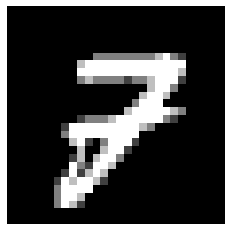

Label: 7


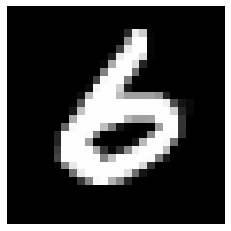

Label: 6


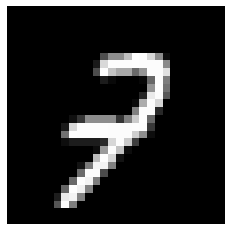

Label: 7


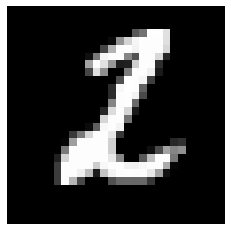

Label: 2


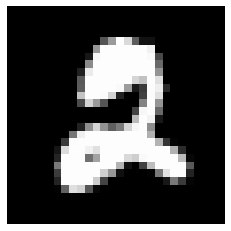

Label: 2


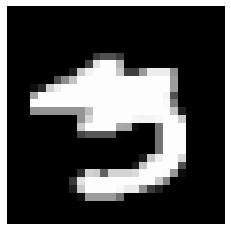

Label: 3


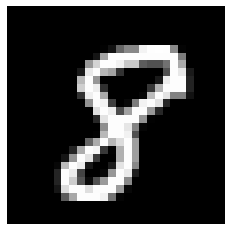

Label: 8


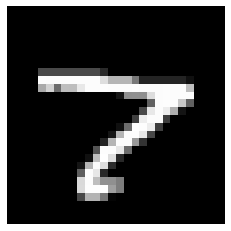

Label: 7


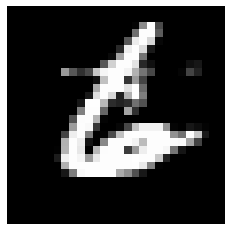

Label: 6


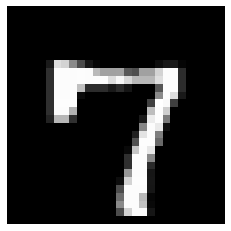

Label: 7


In [5]:
plot_test_images()

We are first going to do softmax logistic regression. This is a linear layer followed by softmax. Note there are NO hidden layers here. Also note that the digit images (28x28 grayscale images) are reshaped into a 784 element vector. 

Below we create the parameters (weights) for our linear layer.

In [6]:
y_regressor = torch.nn.Linear(784, 10)

We then initialize the weights and biases to zero.

In [7]:
torch.nn.init.zeros_(y_regressor.weight)
t = torch.nn.init.zeros_(y_regressor.bias)

We create our network, which has only the aforemntioned linear layer.

In [8]:
model_sr = torch.nn.Sequential(y_regressor)

Below we create our loss function. Note that the cross entropy is $ H_{\hat{y}}(y) = -\sum_i \hat{y}_{i} \, \log(y_{i})$ where $\hat{y}$ is the true probability distribution and is expressed as a one-hot vector, $y$ is the estimated probability distribution, and $i$ indexes elements of these two vectors. Also note that this reduces to $ H_{\hat{y}}(y) = -\, \log(y_{i^*})$ where $i^*$ is the correct label. And if we sum this over all of our samples indexed by $j$, then $H_{\hat{y}}(y) = -\sum_j  \log(y^{(j)}_{i^*})$. This is precisely the same loss function as we used before, but we called the MLE loss. They are one and the same.

In [9]:
loss_fn_sr = torch.nn.CrossEntropyLoss(reduction = 'mean')

Now we tell PyTorch to use Stochastic Gradient Descent (SGD) with a step size of 0.5.

In [10]:
optim_sr = torch.optim.SGD(model_sr.parameters(), lr = 0.5)

We train by grabbing mini-batches with 100 samples each, pushing these through the network, computing the loss, and backpropagating to update model parameters (in this case, the weights and biases in the linear layer).

Batch 0, training accuracy 13.0%, training loss 2.302585
Batch 100, training accuracy 86.0%, training loss 1.060962
Batch 200, training accuracy 83.0%, training loss 0.793021
Batch 300, training accuracy 76.0%, training loss 1.614426
Batch 400, training accuracy 85.0%, training loss 0.950697
Batch 500, training accuracy 91.0%, training loss 0.956676
Batch 600, training accuracy 86.0%, training loss 0.581585
Batch 700, training accuracy 80.0%, training loss 0.966287
Batch 800, training accuracy 89.0%, training loss 0.604547
Batch 900, training accuracy 88.0%, training loss 0.552309
Best model: validation accuracy 92.6%, validation loss 0.431353


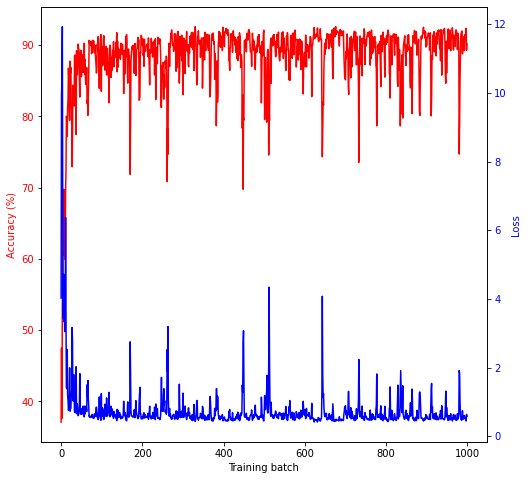

In [11]:
best_model_sr, valid_acc_list_sr, valid_loss_list_sr = train_model(model_sr, optim_sr, loss_fn_sr)

Compute accuracy on the test set.

In [12]:
accuracy_test(best_model_sr)

The accuracy of the model is 90.5%


Print out some test images and the corresponding predictions made by the network. 

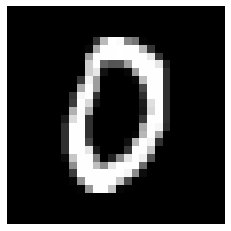

Label: 0
Class probabilities: 1.000e+00, 4.320e-22, 1.642e-06, 1.259e-10, 5.616e-17, 1.351e-10, 1.519e-09, 3.030e-14, 2.005e-08, 1.240e-10
Predicted class: 0


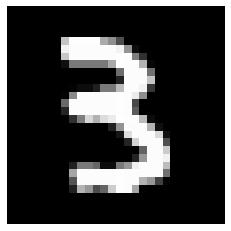

Label: 3
Class probabilities: 6.868e-13, 1.782e-10, 1.697e-09, 1.000e+00, 1.696e-11, 1.754e-05, 3.546e-10, 6.433e-15, 8.188e-08, 6.029e-07
Predicted class: 3


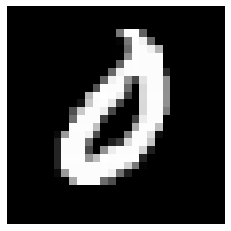

Label: 0
Class probabilities: 1.000e+00, 7.086e-17, 2.336e-05, 1.338e-07, 8.465e-10, 3.884e-06, 7.418e-06, 3.449e-10, 4.666e-08, 4.212e-06
Predicted class: 0


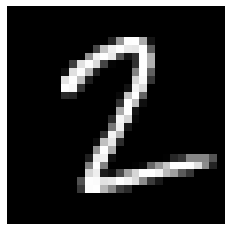

Label: 2
Class probabilities: 1.013e-11, 4.079e-04, 9.994e-01, 2.712e-05, 6.126e-14, 2.807e-05, 1.209e-08, 5.123e-12, 1.014e-04, 6.580e-13
Predicted class: 2


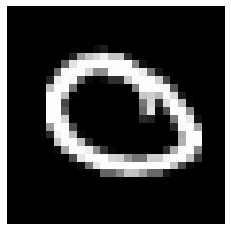

Label: 0
Class probabilities: 9.972e-01, 5.331e-14, 2.789e-03, 7.348e-10, 9.169e-18, 2.070e-14, 9.243e-07, 6.448e-06, 3.522e-12, 6.804e-07
Predicted class: 0


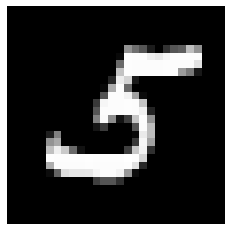

Label: 5
Class probabilities: 2.442e-08, 1.660e-10, 5.344e-09, 2.579e-04, 1.567e-18, 9.997e-01, 8.707e-11, 1.006e-13, 2.916e-10, 6.490e-13
Predicted class: 5


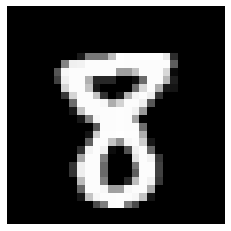

Label: 8
Class probabilities: 5.791e-17, 3.898e-16, 2.004e-11, 8.752e-10, 2.383e-14, 2.760e-07, 4.915e-15, 3.742e-15, 1.000e+00, 1.021e-08
Predicted class: 8


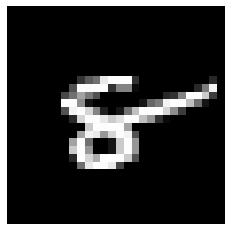

Label: 8
Class probabilities: 1.654e-10, 2.271e-08, 8.088e-07, 7.571e-17, 2.378e-01, 1.670e-09, 7.587e-01, 1.592e-12, 9.249e-04, 2.554e-03
Predicted class: 6


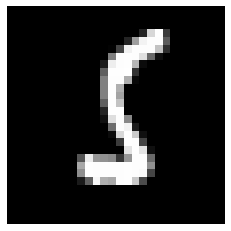

Label: 5
Class probabilities: 1.914e-09, 7.453e-04, 3.842e-02, 2.790e-02, 1.163e-15, 2.137e-02, 9.115e-01, 2.129e-12, 5.731e-05, 5.425e-10
Predicted class: 6


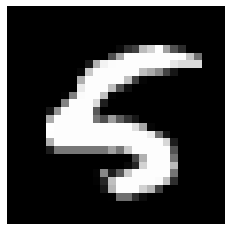

Label: 5
Class probabilities: 1.100e-04, 3.018e-15, 1.921e-04, 5.224e-16, 9.054e-01, 1.893e-03, 9.226e-02, 1.530e-18, 9.294e-05, 1.056e-06
Predicted class: 4


In [13]:
plot_test_images(best_model_sr)

## Softmax Multi-Layer Perceptron on the MNIST Digits Data

Here the weights are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLU.
The limits of the truncated normal are -0.2 and 0.2, which corresponds to two standard deviations on either side of the mean (this is the default in TensorFlow for a truncated normal).

We create the first hidden layer (i.e., the input layer) with 512 neurons, and we initialize the layer weights as described above.

In [14]:
# Create layer (784 input elements, 512 neurons)
h = torch.nn.Linear(784, 512)

# Initialize the weights by sampling from a truncated normal distribution with 
# mean 0, standard deviation 0.1, and limits two standard deviations from 
# the mean (-0.2 to 0.2)
torch.nn.init.trunc_normal_(h.weight, std = 0.1, a = -0.2, b = 0.2) 

# Initialize biases to 0.1
t = torch.nn.init.constant_(h.bias, 0.1)

Create a ReLU layer to follow the input layer.

In [15]:
h_relu = torch.nn.ReLU()

We create the output layer and initialize its weights and biases in the same way as the hidden layer.

In [16]:
h_out = torch.nn.Linear(512, 10)
torch.nn.init.trunc_normal_(h_out.weight, std = 0.1, a = -0.2, b = 0.2) 
t = torch.nn.init.constant_(h_out.bias, 0.1)

Create the model by assembling the layers defined above. As before, we use cross entropy loss. For training, we choose an Adam learning rate and update rule.

In [17]:
model_mlp = torch.nn.Sequential(h, h_relu, h_out)
loss_fn_mlp = torch.nn.CrossEntropyLoss(reduction = 'mean')
optim_mlp = torch.optim.Adam(model_mlp.parameters(), lr = 1e-4)

Train the model.

Batch 0, training accuracy 0.0%, training loss 6.047276
Batch 100, training accuracy 64.0%, training loss 1.087532
Batch 200, training accuracy 88.0%, training loss 0.342560
Batch 300, training accuracy 86.0%, training loss 0.549440
Batch 400, training accuracy 88.0%, training loss 0.538355
Batch 500, training accuracy 88.0%, training loss 0.364041
Batch 600, training accuracy 82.0%, training loss 0.459302
Batch 700, training accuracy 86.0%, training loss 0.316574
Batch 800, training accuracy 94.0%, training loss 0.177902
Batch 900, training accuracy 94.0%, training loss 0.196890
Best model: validation accuracy 93.9%, validation loss 0.210774


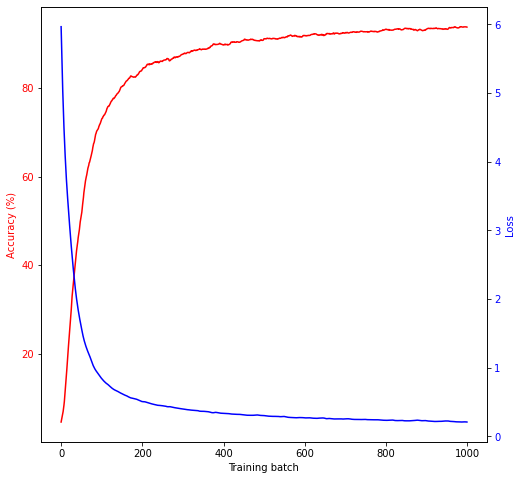

In [18]:
best_model_mlp, valid_acc_list_mlp, valid_loss_list_mlp = train_model(model_mlp, optim_mlp, loss_fn_mlp, batch_size = 50)

Compute accuracy on the test set.

In [19]:
accuracy_test(best_model_mlp, batch_size = 50)

The accuracy of the model is 92.3%


Print out some test images and the corresponding predictions made by the network.

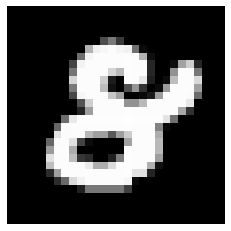

Label: 8
Class probabilities: 1.175e-01, 9.328e-06, 1.945e-02, 3.122e-02, 1.288e-04, 2.385e-01, 3.491e-03, 3.293e-05, 5.863e-01, 3.363e-03
Predicted class: 8


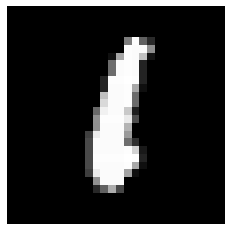

Label: 1
Class probabilities: 8.788e-06, 9.542e-01, 7.728e-03, 4.456e-04, 7.373e-06, 3.026e-04, 1.403e-02, 3.721e-05, 2.319e-02, 7.226e-06
Predicted class: 1


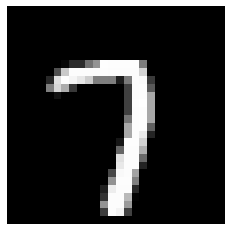

Label: 7
Class probabilities: 1.469e-05, 1.738e-06, 5.512e-05, 1.545e-03, 1.796e-06, 2.680e-05, 8.191e-07, 9.943e-01, 2.309e-06, 4.091e-03
Predicted class: 7


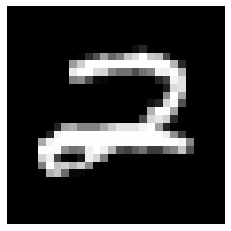

Label: 2
Class probabilities: 3.664e-05, 1.440e-06, 9.978e-01, 2.936e-04, 7.421e-05, 7.967e-06, 1.196e-05, 3.792e-05, 3.896e-06, 1.729e-03
Predicted class: 2


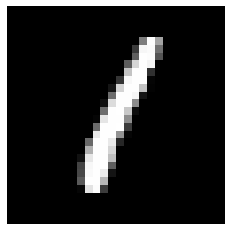

Label: 1
Class probabilities: 6.829e-05, 9.890e-01, 3.696e-03, 1.335e-03, 5.851e-05, 2.731e-04, 1.919e-04, 2.393e-04, 5.080e-03, 1.762e-05
Predicted class: 1


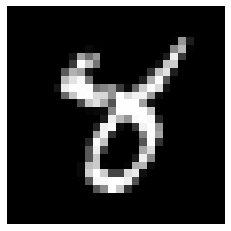

Label: 8
Class probabilities: 2.174e-06, 9.490e-05, 8.736e-06, 3.206e-03, 2.151e-01, 3.346e-03, 2.101e-04, 3.665e-02, 7.393e-01, 2.096e-03
Predicted class: 8


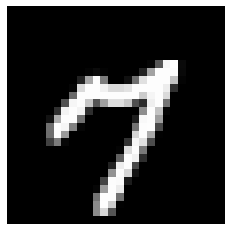

Label: 7
Class probabilities: 3.982e-05, 1.125e-05, 6.738e-07, 1.373e-04, 3.017e-03, 2.038e-03, 2.873e-06, 9.930e-01, 1.276e-04, 1.603e-03
Predicted class: 7


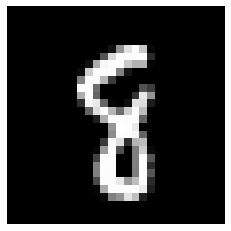

Label: 8
Class probabilities: 1.083e-04, 2.930e-04, 3.161e-03, 6.581e-04, 7.739e-03, 1.290e-02, 4.266e-04, 2.895e-04, 9.602e-01, 1.424e-02
Predicted class: 8


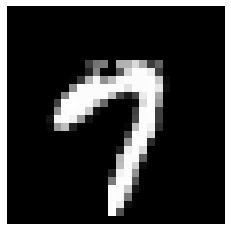

Label: 7
Class probabilities: 2.403e-05, 8.297e-08, 1.233e-07, 4.911e-06, 4.315e-04, 1.418e-04, 4.579e-06, 9.694e-01, 2.462e-06, 3.002e-02
Predicted class: 7


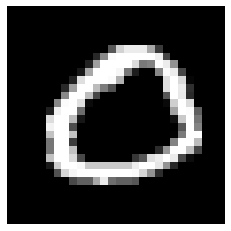

Label: 0
Class probabilities: 1.000e+00, 6.569e-08, 1.301e-05, 1.846e-07, 1.439e-10, 2.526e-05, 2.866e-06, 3.642e-09, 1.798e-07, 3.334e-06
Predicted class: 0


In [20]:
plot_test_images(best_model_mlp)

## A Simple Convolutional Neural Network

Here we make our first CNN. It's quite simple network, but it's surprisingly good at this handwritten digit recognition task. This a variant on Yann LeCun's CNN network that really helped to move deep learning forward.

Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLU.

The convolution will use a 5x5 kernel and will pad the image with zeros around the edges and use a stride of 1 pixel so that the resulting image (after convolution) has the same size as the original input image. The network will learn the weights for a stack of 32 separate kernels along with 32 bias variables. Finally, after the ReLU is performed the result will undergo 2x2 max pooling, thus halving both dimensions of the image. The choices for the stride, padding, and pooling are not parameters that the network needs to estimate. Rather these are termed "hyperparamters" that are usually set by the network designer.

The second layer will have to process 32 feature images coming out of the first layer. Note that the images input to this layer have $\frac{1}{4}$ the number of pixels as the original input images due to the 2x2 pooling in the previous layer. Note that convolution layer NOT fully connected as our previous hidden layers have been. A unit in the output layer has a limited "receptive field." Its connections to the input layer are spatially limited by the kernel (or filter) size. Also, because of weight sharing in convolutional layers, the number of parameters for a convolutional is the size of the kernel x the depth of the input layer x depth of the output layer + depth of the output layer. So for the second layer of our ConvNet, we have 5 x 5 x 32 x 64 + 64 = 51,264 parameters.

After the pooling stage of our second convolutional layer, we have 64 7x7 "feature" images. In one penultimate fully connected hidden layer, we are going to map these feature imges to a 1024 dimensional feature space. Note we need to flatten these feature images to do this.

Dropout is added as well, although it is not really needed for such small network.

We have a final linear output layer mapping features to scores topped off with a softmax cross entropy loss function, as explained earlier.

In [21]:
# Define the CNN as a Torch module
class CNNModel(torch.nn.Module):
  def __init__(self):
      # Run the init of the parent class
      super(CNNModel, self).__init__()
      # Convolutional layers
      self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 2, stride = 1, bias = True)
      self.conv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 2, bias = True)
      # Fully connected linear layers
      self.fc1 = torch.nn.Linear(3136, 1024, bias = True)
      self.fc2 = torch.nn.Linear(1024, 10, bias = True)
      # Dropout layer
      self.Dropout = torch.nn.Dropout(p = 0.5) # Create the dropout layer

  def forward(self, x):
      # Convolutional layer 1, ReLU, and pooling
      x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = (2), stride = (2), padding = 0)
      # Convolutional layer 2, ReLU, and pooling
      x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = (2), stride = (2), padding = 0)
      # Flatten the image
      x = x.view(-1, 3136)
      # First fully connected layer
      x = F.relu(self.fc1(x))
      # Dropout layer
      x = self.Dropout(x)
      # Second fully connected layer
      x = self.fc2(x)
      # Done
      return x

Assemble the model. Use cross entropy loss as before. For training, we choose an Adam learning rate and update rule.

In [26]:
model_cnn = CNNModel()
loss_fn_cnn = torch.nn.CrossEntropyLoss()
optim_cnn = torch.optim.Adam(model_cnn.parameters(), lr = 1e-4)

Train the model.

Batch 0, training accuracy 12.0%, training loss 2.315898
Batch 100, training accuracy 86.0%, training loss 0.448477
Batch 200, training accuracy 92.0%, training loss 0.285947
Batch 300, training accuracy 94.0%, training loss 0.165569
Batch 400, training accuracy 94.0%, training loss 0.152255
Batch 500, training accuracy 98.0%, training loss 0.121800
Batch 600, training accuracy 96.0%, training loss 0.126298
Batch 700, training accuracy 96.0%, training loss 0.127581
Batch 800, training accuracy 94.0%, training loss 0.217817
Batch 900, training accuracy 98.0%, training loss 0.086537
Best model: validation accuracy 97.9%, validation loss 0.083711


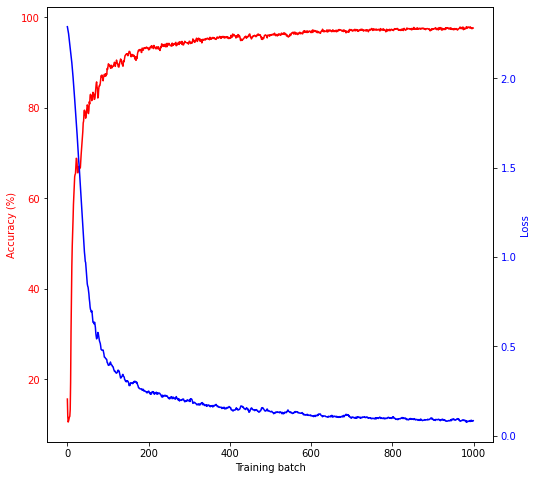

In [27]:
best_model_cnn, valid_acc_list_cnn, valid_loss_list_cnn = train_model(model_cnn, optim_cnn, loss_fn_cnn, batch_size = 50, format_cnn = True)

Compute accuracy on the test set.

In [28]:
accuracy_test(best_model_cnn, batch_size = 50, format_cnn = True)

The accuracy of the model is 97.3%


Print out some test images and the corresponding predictions made by the network.

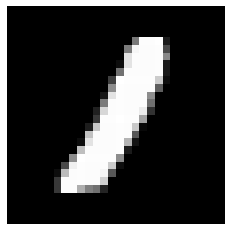

Label: 1
Class probabilities: 1.721e-04, 9.873e-01, 2.571e-03, 3.097e-04, 5.047e-04, 2.025e-06, 9.137e-05, 7.192e-04, 8.222e-03, 1.163e-04
Predicted class: 1


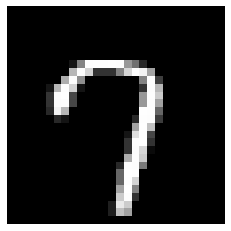

Label: 7
Class probabilities: 1.886e-05, 1.250e-05, 1.847e-05, 3.440e-05, 1.165e-05, 3.851e-06, 2.001e-08, 9.984e-01, 1.365e-06, 1.544e-03
Predicted class: 7


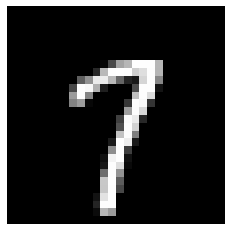

Label: 7
Class probabilities: 5.539e-06, 8.596e-05, 3.797e-05, 1.840e-04, 1.251e-05, 6.084e-07, 1.845e-08, 9.966e-01, 3.027e-05, 3.056e-03
Predicted class: 7


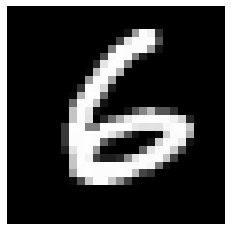

Label: 6
Class probabilities: 5.348e-05, 3.021e-09, 1.950e-06, 2.377e-08, 3.436e-06, 5.946e-05, 9.999e-01, 1.600e-10, 1.529e-05, 1.314e-07
Predicted class: 6


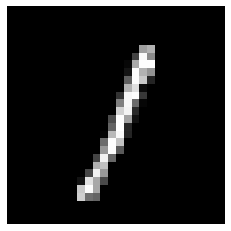

Label: 1
Class probabilities: 8.642e-04, 9.495e-01, 9.983e-04, 2.644e-03, 1.585e-02, 7.696e-05, 4.396e-04, 2.819e-02, 3.575e-04, 1.035e-03
Predicted class: 1


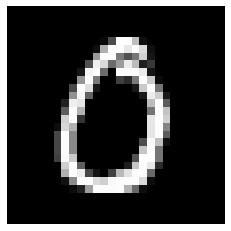

Label: 0
Class probabilities: 9.992e-01, 2.583e-07, 1.044e-04, 1.905e-05, 1.546e-06, 1.141e-05, 9.525e-05, 2.986e-05, 2.451e-05, 4.770e-04
Predicted class: 0


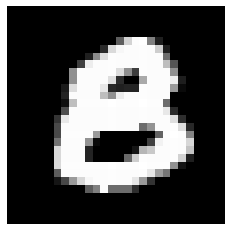

Label: 8
Class probabilities: 1.369e-01, 2.363e-06, 1.390e-03, 4.288e-02, 3.536e-04, 5.772e-03, 1.545e-02, 2.005e-06, 7.783e-01, 1.894e-02
Predicted class: 8


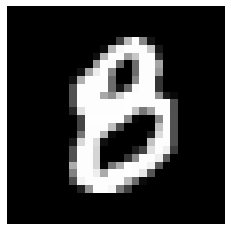

Label: 8
Class probabilities: 6.333e-01, 5.859e-06, 5.034e-04, 5.223e-03, 1.040e-03, 3.672e-03, 9.887e-02, 7.729e-06, 2.552e-01, 2.235e-03
Predicted class: 0


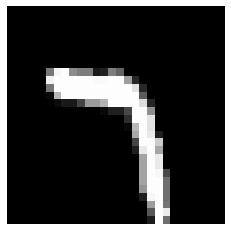

Label: 7
Class probabilities: 5.532e-07, 1.514e-04, 3.185e-04, 1.522e-02, 5.668e-05, 6.536e-04, 1.033e-07, 9.582e-01, 6.594e-04, 2.477e-02
Predicted class: 7


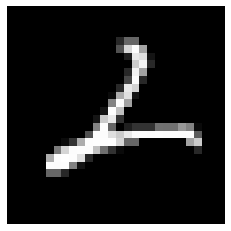

Label: 2
Class probabilities: 2.450e-04, 2.449e-02, 9.326e-01, 1.073e-02, 2.281e-02, 3.543e-04, 2.488e-03, 3.575e-03, 2.648e-03, 5.202e-05
Predicted class: 2


In [29]:
plot_test_images(best_model_cnn, format_cnn = True)